In [1]:
from numpy.linalg import norm
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.validation import check_is_fitted, check_array, check_X_y, check_random_state
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from LMNN import LargeMarginNearestNeighbor
from LMNN_SS import SemiSupervisedLargeMarginNearestNeighbor
from lmnn import LargeMarginNearestNeighbor as l_LargeMarginNearestNeighbor

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt


from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd

import cv2

import time

# Metrics Learning 

**Group Members: Oskar Hint , Xiaoshen Hou,  Kasper Schønberg,  Valentine Van Der Nya**




### Test 0

In [6]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

sample_inds=np.random.randint(X_train.shape[0], size=5)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]
new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

knn=KNeighborsClassifier(n_neighbors=1)
lmnn=LargeMarginNearestNeighbor(n_neighbors=1)
ssc=SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=1,X_unlabeled=new_X_train)


l_lmnn = l_LargeMarginNearestNeighbor(n_neighbors=1)


knn.fit(X_train_labelled, y_train_labelled)
lmnn.fit(X_train_labelled, y_train_labelled)
ssc.fit(X_train_labelled, y_train_labelled)
l_lmnn.fit(X_train_labelled, y_train_labelled) # doctest: +ELLIPSIS
print knn.score(X_test,y_test)
print lmnn.score(X_test,y_test)
print ssc.score(X_test,y_test)
print l_lmnn.score(X_test,y_test) # doctest: +ELLIPSIS

ValueError: At least one class has less than 2 (1) training samples.

***
## Tuning hyper-parameters Grid

In [7]:
###Benchmark Grid Search Hyperparameters K, omega1,2, 3 #############
K=[1,2,3,4,5]
omega0= np.arange(0.1,1,0.1)
omega1= np.arange(0.1,1,0.1)
omega2= np.arange(0.1,1,0.1)

knn_param_grid = {'n_neighbors': K}
lmnn_param_grid = {'n_neighbors': K, 'omega': omega0}


***
## 1.  Experinment 1 - USPS data 

<img src="ml_data/USPS_MNIST.gif">

In [53]:
print ("Parameters Grid for LMNN test ")
lmnn_param_grid

Parameters Grid for LMNN test 


{'n_neighbors': [1, 2, 3, 4, 5],
 'omega': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}

In [8]:
def get_USPS_training_data():
    data = load_svmlight_file('ml_data/usps/usps')
    return data[0], data[1]

def get_USPS_testing_data():
    data = load_svmlight_file('ml_data/usps/usps.t')
    return data[0], data[1]

X_train, y_train = get_USPS_training_data()
X_test, y_test = get_USPS_testing_data()

X_train=np.asarray(X_train.todense())
y_train=np.asarray(y_train)
X_test=np.asarray(X_test.todense())
y_test=np.asarray(y_test)

In [12]:
######## Sample label, unlabel set  from training #########

sample_inds=np.random.randint(X_train.shape[0], size=100)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=2000)
X_train_unlabelled=new_X_train[sample_inds, :]



In [32]:
##### LMNN TUNNING USPS ########  (Long execution!!)
knnclf = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, verbose=3)
knnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(knnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = knnclf.cv_results_['mean_test_score']
stds = knnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, knnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, knnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_neighbors=1 ...................................................
[CV] .............. n_neighbors=1, score=0.789473684211, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.875, total=   0.0s
[CV] n_neighbors=1 ...................................................
[CV] .............. n_neighbors=1, score=0.866666666667, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .............. n_neighbors=2, score=0.815789473684, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.875, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] ......................... n_neighbors=2, score=0.8, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


In [17]:
##### LMNN TUNNING USPS ########  (Long execution!!)
lmnnclf = GridSearchCV(LargeMarginNearestNeighbor(max_iter=100), lmnn_param_grid, cv=3, n_jobs=20, verbose=3)
lmnnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(lmnnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = lmnnclf.cv_results_['mean_test_score']
stds = lmnnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lmnnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, lmnnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] n_neighbors=1, omega=0.1 ........................................
[CV] n_neighbors=1, omega=0.30000000000000004 ........................
[CV] n_neighbors=1, omega=0.1 ........................................
[CV] n_neighbors=1, omega=0.1 ........................................
[CV] n_neighbors=1, omega=0.2 ........................................
[CV] n_neighbors=1, omega=0.2 ........................................
[CV] n_neighbors=1, omega=0.2 ........................................
[CV] n_neighbors=1, omega=0.30000000000000004 ........................
[CV] n_neighbors=1, omega=0.30000000000000004 ........................
[CV] n_neighbors=1, omega=0.4 ........................................
[CV] n_neighbors=1, omega=0.4 ........................................
[CV] n_neighbors=1, omega=0.5 ........................................
[CV] n_neighbors=1, omega=0.4 ........................................
[CV] n_neighbor

[CV]  n_neighbors=2, omega=0.7000000000000001, score=0.6, total=  40.6s
[CV] n_neighbors=3, omega=0.5 ........................................
[CV]  n_neighbors=2, omega=0.7000000000000001, score=0.75, total=  41.7s
[CV] n_neighbors=3, omega=0.5 ........................................
[CV] .......... n_neighbors=2, omega=0.9, score=0.71875, total=  35.9s
[CV] n_neighbors=3, omega=0.6 ........................................
[CV] ... n_neighbors=2, omega=0.9, score=0.533333333333, total=  35.7s
[CV] n_neighbors=3, omega=0.6 ........................................
[CV] ... n_neighbors=3, omega=0.1, score=0.815789473684, total=  36.3s
[CV] n_neighbors=3, omega=0.6 ........................................
[CV]  n_neighbors=3, omega=0.30000000000000004, score=0.71875, total=  27.3s
[CV] n_neighbors=3, omega=0.7000000000000001 .........................
[CV] .............. n_neighbors=3, omega=0.1, score=0.8, total=  37.0s
[CV] n_neighbors=3, omega=0.7000000000000001 .......................

[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:  3.0min


[CV] ... n_neighbors=4, omega=0.2, score=0.763157894737, total=  46.3s
[CV] n_neighbors=5, omega=0.1 ........................................
[CV] .............. n_neighbors=3, omega=0.6, score=0.6, total= 1.1min
[CV] n_neighbors=5, omega=0.1 ........................................
[CV] ... n_neighbors=4, omega=0.6, score=0.736842105263, total=  19.9s
[CV] n_neighbors=5, omega=0.1 ........................................
[CV] ... n_neighbors=3, omega=0.8, score=0.566666666667, total= 1.1min
[CV] n_neighbors=5, omega=0.2 ........................................
[CV] ............. n_neighbors=4, omega=0.2, score=0.75, total=  51.0s
[CV] n_neighbors=5, omega=0.2 ........................................
[CV] ... n_neighbors=4, omega=0.4, score=0.766666666667, total=  37.8s
[CV] n_neighbors=5, omega=0.2 ........................................
[CV]  n_neighbors=4, omega=0.7000000000000001, score=0.763157894737, total=  23.6s
[CV] n_neighbors=5, omega=0.30000000000000004 ...................

[Parallel(n_jobs=20)]: Done 135 out of 135 | elapsed:  4.7min finished


LMNN Best parameters set found on development set:
()
{'n_neighbors': 1, 'omega': 0.1}
()
Grid scores on development set:
()
0.810 (+/-0.092) for {'n_neighbors': 1, 'omega': 0.1}
0.790 (+/-0.101) for {'n_neighbors': 1, 'omega': 0.2}
0.780 (+/-0.114) for {'n_neighbors': 1, 'omega': 0.30000000000000004}
0.780 (+/-0.114) for {'n_neighbors': 1, 'omega': 0.4}
0.800 (+/-0.089) for {'n_neighbors': 1, 'omega': 0.5}
0.690 (+/-0.119) for {'n_neighbors': 1, 'omega': 0.6}
0.680 (+/-0.152) for {'n_neighbors': 1, 'omega': 0.7000000000000001}
0.700 (+/-0.175) for {'n_neighbors': 1, 'omega': 0.8}
0.670 (+/-0.180) for {'n_neighbors': 1, 'omega': 0.9}
0.770 (+/-0.071) for {'n_neighbors': 2, 'omega': 0.1}
0.760 (+/-0.064) for {'n_neighbors': 2, 'omega': 0.2}
0.760 (+/-0.054) for {'n_neighbors': 2, 'omega': 0.30000000000000004}
0.760 (+/-0.054) for {'n_neighbors': 2, 'omega': 0.4}
0.780 (+/-0.030) for {'n_neighbors': 2, 'omega': 0.5}
0.690 (+/-0.119) for {'n_neighbors': 2, 'omega': 0.6}
0.720 (+/-0.161) f

In [26]:
omega0=[lmnnclf.best_params_['omega']]
omega1= np.arange(0.1,1,0.2)
omega2= np.arange(0.1,1,0.2)
ssc_param_grid = {'n_neighbors': K, 'omega0': omega0,'omega1': omega1,'omega2': omega2}

In [31]:
##### SSC LMNN TUNNING USPS ######## (Long execution!!)
sscclf = GridSearchCV(SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=100), ssc_param_grid, cv=3, verbose=3)
sscclf.fit(X_train_labelled, y_train_labelled)

print("SSC Best parameters set found on development set:")
print()
print(sscclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = sscclf.cv_results_['mean_test_score']
stds = sscclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, sscclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, sscclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 3 folds for each of 125 candidates, totalling 375 fits
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1, score=0.815789473684, total=  42.3s
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.3s remaining:    0.0s


[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1, score=0.8125, total=  55.3s
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1, score=0.766666666667, total= 1.0min
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.815789473684, total= 1.1min
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.8125, total= 1.0min
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.766666666667, total=  55.4s
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.5000000000000001, score=0.815789473684, total= 1.9min
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.5000000000000001, score=0.78125, total=  36.2s
[CV] n_neighbors=1, o

[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.1, score=0.833333333333, total= 1.0min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.842105263158, total= 1.6min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.84375, total= 1.3min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.766666666667, total= 1.1min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.789473684211, total=  45.9s
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1

[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.1, score=0.815789473684, total= 2.3min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.1, score=0.875, total= 2.8min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.1, score=0.766666666667, total= 1.4min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004, score=0.815789473684, total= 1.2min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004, score=0.84375, total= 1.5min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.3

[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.1, omega2=0.9000000000000001, score=0.868421052632, total= 3.3min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.1, omega2=0.9000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.1, omega2=0.9000000000000001, score=0.75, total= 1.6min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.1, omega2=0.9000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.1, omega2=0.9000000000000001, score=0.733333333333, total= 2.4min
[CV] n_neighbors=2, omega1=0.9000000000000001, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.9000000000000001, omega0=0.1, omega2=0.1, score=0.789473684211, total= 1.7min
[CV] n_neighbors=2, omega1=0.9000000000000001, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.9000000000000001, omega0=0.1, omega2=0.1, score=0.875, total= 2.9min
[CV] n_neighbors=2, omega1=0.9000000000000001, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.9000000000000001, o

[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001, score=0.78125, total= 1.3min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001, score=0.733333333333, total= 1.2min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9000000000000001 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9000000000000001, score=0.789473684211, total=  56.4s
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9000000000000001 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9000000000000001, score=0.78125, total= 2.0min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9000000000000001 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9000000000000001, score=0.766666666667, total= 1.5min
[CV] n_neighbors=3, omega1=0.5000000000000001,

[CV]  n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.842105263158, total= 1.8min
[CV] n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.78125, total=  55.9s
[CV] n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.733333333333, total= 1.6min
[CV] n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.7000000000000001, score=0.789473684211, total=  35.5s
[CV] n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.9000000000000001, omega0=0.1, omega2=0.7000000000000001, score=0.78125, total= 1.6min
[CV] n_neighbors=3, omega1=0.9000000000000001, omega0=0

[CV]  n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.733333333333, total= 1.7min
[CV] n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.815789473684, total= 1.4min
[CV] n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.8125, total= 1.9min
[CV] n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.5000000000000001, score=0.7, total= 1.9min
[CV] n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, omega2=0.7000000000000001, score=0.815789473684, total= 1.7min
[CV] n_neighbors=4, omega1=0.5000000000000001, omega0=0.1, 

[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.1, score=0.8, total=  55.3s
[CV] n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.789473684211, total=  58.5s
[CV] n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.78125, total=  53.4s
[CV] n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.7, total=  51.8s
[CV] n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.5000000000000001, score=0.815789473684, total= 1.6min
[CV] n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.5000000000000001, score=0.78125, total=  33.9s
[CV] n_neighbors=5, omega1=0.1, omega0=0.1

[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.1, score=0.84375, total= 1.8min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.1, score=0.8, total= 1.1min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.789473684211, total= 1.6min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.78125, total= 1.3min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.766666666667, total= 1.1min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.5000000000000001 
[CV]  n_neighbors=5

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 611.2min finished


SSC Best parameters set found on development set:
()
{'n_neighbors': 4, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.7000000000000001}
()
Grid scores on development set:
()
0.800 (+/-0.044) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.1}
0.800 (+/-0.044) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.30000000000000004}
0.790 (+/-0.042) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.5000000000000001}
0.810 (+/-0.036) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.7000000000000001}
0.800 (+/-0.067) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.9000000000000001}
0.820 (+/-0.086) for {'n_neighbors': 1, 'omega1': 0.30000000000000004, 'omega0': 0.1, 'omega2': 0.1}
0.800 (+/-0.029) for {'n_neighbors': 1, 'omega1': 0.30000000000000004, 'omega0': 0.1, 'omega2': 0.30000000000000004}
0.810 (+/-0.062) for {'n_neighbors': 1, 'omega1': 0.30000000000000004, 'omega0': 0.1, 'omega2': 0.5000000000000001}
0.800 (+/-

In [33]:
print "KNN Best Hyperpara:", knnclf.best_params_
print "LMNN Best Hyperpara:", lmnnclf.best_params_
print "SSC Best Hyperpara:", sscclf.best_params_

KNN Best Hyperpara: {'n_neighbors': 1}
LMNN Best Hyperpara: {'n_neighbors': 1, 'omega': 0.1}
SSC Best Hyperpara: {'n_neighbors': 4, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.7000000000000001}


### Fit Tuned hyper-parameters on KNN/LMNN/SSC

In [37]:
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds, :]

print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.1)
k, omega0, omega1, omega2 =(4, 0.1, 0.1, 0.7)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("USPS KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega,max_iter=150)
lmnn.fit(X_train_labelled,y_train_labelled)
print("USPS LMNN : ", lmnn.score(X_test,y_test))


l_lmnn = l_LargeMarginNearestNeighbor(n_neighbors=k)
l_lmnn.fit(X_train_labelled, y_train_labelled)
print("USPS Johnny LMNN : ", l_lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled,max_iter=150)
ssc.fit(X_train_labelled, y_train_labelled)
print("USPS SSC : ", ssc.score(X_test,y_test))



('######## Performance Test:  Labelled = ', (200, 256), '  ###  Unlabelled = ', (4000, 256), '###########')
('########  K = ', 4, ' ###########')
('USPS KNN : ', 0.8136522172396612)
('USPS LMNN : ', 0.8470353761833582)
('USPS Johnny LMNN : ', 0.6751370204285002)
('USPS SSC : ', 0.8495266567015446)


### Fit Tuned hyper-parameters SSC with different porpotional unlabelld data (Labelled=200)

In [40]:
lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega,max_iter=150)
lmnn.fit(X_train_labelled,y_train_labelled)
base_acc=lmnn.score(X_test,y_test)
print "label size: 200 USPS SSC : ", base_acc

acc_list=list()    
unlabel_sizes=[1000,2000,3000,4000,new_X_train.shape[0]]

for unlabel_size in unlabel_sizes:
    
    sample_inds=np.random.randint(new_X_train.shape[0], size=unlabel_size)
    X_train_unlabelled=new_X_train[sample_inds, :]
    ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2, X_unlabeled=X_train_unlabelled,max_iter=150)
    ssc.fit(X_train_labelled, y_train_labelled)
    acc= ssc.score(X_test,y_test)
    acc_list.append(acc)
    print "Unlabel size: ", unlabel_size," USPS SSC : ", acc

label size: 200 USPS SSC :  0.8470353761833582
Unlabel size:  1000  USPS SSC :  0.833582461385152
Unlabel size:  2000  USPS SSC :  0.8370702541106129
Unlabel size:  3000  USPS SSC :  0.8565022421524664
Unlabel size:  4000  USPS SSC :  0.8380667663178873
Unlabel size:  7093  USPS SSC :  0.8525161933233683


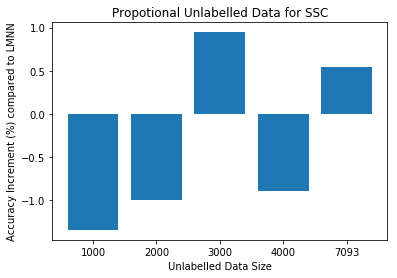

In [41]:
norm_accs=np.array(acc_list) - base_acc
x=np.arange(len(norm_accs))
fig, ax = plt.subplots()
plt.bar(x, norm_accs*100)
plt.xticks(x, unlabel_sizes)
plt.xlabel('Unlabelled Data Size')
plt.ylabel('Accuracy Increment (%) compared to LMNN')
plt.title('Propotional Unlabelled Data for SSC')
plt.show()

***
## 2.  Experinment 2 - MNIST data 

In [42]:
mnist = fetch_mldata('MNIST original', data_home='ml_data/mnist')  #Download MMNIST

In [43]:
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [44]:
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds, :]

print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.1)
k, omega0, omega1, omega2 =(4, 0.1, 0.1, 0.7)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("MNIST KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega,max_iter=150)
lmnn.fit(X_train_labelled,y_train_labelled)
print("MNIST LMNN : ", lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled,max_iter=150)
ssc.fit(X_train_labelled, y_train_labelled)
print("MNIST SSC : ", ssc.score(X_test,y_test))

('######## Performance Test:  Labelled = ', (200, 784), '  ###  Unlabelled = ', (4000, 784), '###########')
('########  K = ', 4, ' ###########')
('MNIST KNN : ', 0.7370857142857142)


KeyboardInterrupt: 

In [60]:
lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega,max_iter=150)
lmnn.fit(X_train_labelled,y_train_labelled)
base_acc=lmnn.score(X_test,y_test)
print "label size: 200 MNIST SSC : ", base_acc

acc_list=list()    
unlabel_sizes=[1000,2000,3000,4000,new_X_train.shape[0]]

for unlabel_size in unlabel_sizes:
    
    sample_inds=np.random.randint(new_X_train.shape[0], size=unlabel_size)
    X_train_unlabelled=new_X_train[sample_inds, :]
    ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled,max_iter=150)
    ssc.fit(X_train_labelled, y_train_labelled)
    acc= ssc.score(X_test,y_test)
    acc_list.append(acc)
    print "Unlabel size: ", unlabel_size," MNIST SSC : ", acc

label size: 200 MNIST SSC :  0.75
Unlabel size:  1000  MNIST SSC :  0.7500571428571429
Unlabel size:  2000  MNIST SSC :  0.7501714285714286
Unlabel size:  3000  MNIST SSC :  0.7501142857142857
Unlabel size:  4000  MNIST SSC :  0.7501428571428571
Unlabel size:  34800  MNIST SSC :  0.7501428571428571


## 3. Experiment - Sign Language Digits  https://www.kaggle.com/ardamavi/sign-language-digits-dataset/version/2

<img src="ml_data/SignLanguage.JPG">

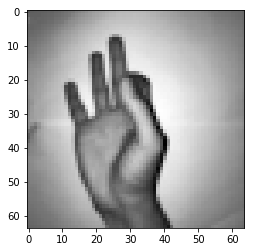

In [28]:
X = np.load('ml_data/Sign-language-digits-dataset/X.npy')
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.imshow(X[0,], cmap='gray')

In [29]:
X = np.load('ml_data/Sign-language-digits-dataset/X.npy')
Y = np.load('ml_data/Sign-language-digits-dataset/Y.npy')
X = X.reshape((X.shape[0], X.shape[1]**2))
Y = np.argwhere(Y == 1)[:,1]


# sample into train and test datasets
train_test_sample_inds=np.random.randint(X.shape[0], size=100)

X_test = X[train_test_sample_inds]
y_test = Y[train_test_sample_inds]

X_train = np.delete(X, train_test_sample_inds,0)
y_train = np.delete(Y, train_test_sample_inds,0)


######## Sample label, unlabel set  from training #########
# keeping 1 to 20 ration of unlabeled to laneled data
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds,:]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=new_X_train.shape[0])
X_train_unlabelled=new_X_train[sample_inds,:]

In [ ]:
print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.3)
k, omega0, omega1, omega2 =(4, 0.4, 0.2, 0.8)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("HANDS KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega)
lmnn.fit(X_train_labelled,y_train_labelled)
print("HANDS LMNN : ", lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
ssc.fit(X_train_labelled, y_train_labelled)
print("HANDS SSC : ", ssc.score(X_test,y_test))

('######## Performance Test:  Labelled = ', (200, 4096), '  ###  Unlabelled = ', (1770, 4096), '###########')
('########  K = ', 4, ' ###########')
('HANDS KNN : ', 0.42)


## 4. Experinment - Devanagari Character Set https://www.kaggle.com/rishianand/devanagari-character-set

In [24]:
#X = np.loadtxt('ml_data/Devanagari/Devanagari.csv',delimiter=',')
df = pd.read_csv('ml_data/Devanagari/Devanagari.csv')
Y=np.array(df['character'].tolist())
df.drop('character', axis=1, inplace=True)
X = df.astype(np.uint8).as_matrix()

# sample into train and test datasets
train_test_sample_inds=np.random.randint(X.shape[0], size=2000)
X_test = X[train_test_sample_inds]
y_test = Y[train_test_sample_inds]

X_train = np.delete(X, train_test_sample_inds,0)
y_train = np.delete(Y, train_test_sample_inds,0)


######## Sample label, unlabel set  from training #########
# keeping 1 to 20 ration of unlabeled to laneled data
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds,:]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds,:]

In [25]:
print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.3)
k, omega0, omega1, omega2 =(4, 0.4, 0.2, 0.8)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("Devanagari KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega)
lmnn.fit(X_train_labelled,y_train_labelled)
print("Devanagari LMNN : ", lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
ssc.fit(X_train_labelled, y_train_labelled)
print("Devanagari SSC : ", ssc.score(X_test,y_test))

('######## Performance Test:  Labelled = ', (200, 1024), '  ###  Unlabelled = ', (4000, 1024), '###########')
('########  K = ', 4, ' ###########')
('Devanagari KNN : ', 0.237)


KeyboardInterrupt: 